In [208]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [209]:
file_path = Path.cwd() / "Daily_Power_Gen_States_march_23.csv"
df=pd.read_csv(file_path)
df.head()

,Region,States,Max.Demand Met during the day(MW),Shortage during maximum Demand(MW),Energy Met (MU),date
0,NER,Mizoram,77,1.0,1.2,2015-01-01
1,WR,DD,214,0.0,4.8,2015-01-01
2,WR,Goa,383,0.0,7.3,2015-01-01
3,WR,Maharashtra,14837,57.0,315.0,2015-01-01
4,WR,MP,5740,0.0,109.8,2015-01-01


In [210]:
df.drop(["Max.Demand Met during the day(MW)","Shortage during maximum Demand(MW)","Region"], axis=1,inplace=True)


In [211]:
df.sort_values(by=['States','Energy Met (MU)'],inplace=True)


In [212]:
df.query("States not in ['AMNSIL','BALCO','DNH','DNHDDPDCL','DVC','Essar steel','Railways_NR ISTS','Pondy', 'Puducherry']",inplace=True)



In [213]:
df['States'].replace({
    'J&K':'Jammu & Kashmir',
    'J&K(UT)':'Jammu & Kashmir',
    'J&K(UT) &':'Jammu & Kashmir',
    'J&K(UT) & \nLadakh(UT)':'Jammu & Kashmir',
    'J&K(UT) & Ladakh(UT)':'Jammu & Kashmir',
    'J&K(UT) and Ladakh(UT)':'Jammu & Kashmir',
    'DD':'Daman & Diu',
    'MP':'Madhya Pradesh',
    'UP':'Uttar Pradesh',
    'HP':'Himachal Pradesh'},
    inplace=True)
df['States']=df['States'].str.strip()



C:\Users\arman\AppData\Local\Temp\ipykernel_10220\2910808681.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['States'].replace({


In [214]:
df.head(10)

,States,Energy Met (MU),date
9806,Andhra Pradesh,93.5,2014-06-03
69887,Andhra Pradesh,96.8,2015-11-17
74251,Andhra Pradesh,101.2,2015-11-18
111468,Andhra Pradesh,101.2,2014-10-27
76371,Andhra Pradesh,103.4,2016-05-19
107341,Andhra Pradesh,104.8,2014-10-26
90965,Andhra Pradesh,105.3,2015-11-22
115674,Andhra Pradesh,105.3,2014-10-28
78433,Andhra Pradesh,105.9,2015-11-19
94752,Andhra Pradesh,106.6,2014-10-23


In [215]:
df_sorted = df.sort_values(by=["States", "date"])

for state, group in df_sorted.groupby("States"):
    print(f"\n--- {state} ---")
    print(group.head(5))


--- Andhra Pradesh ---
                States  Energy Met (MU)        date
124744  Andhra Pradesh            253.7  2013-03-31
1145    Andhra Pradesh            248.5  2013-04-01
5194    Andhra Pradesh            249.0  2013-04-02
9201    Andhra Pradesh            249.0  2013-04-03
13231   Andhra Pradesh            253.9  2013-04-04

--- Arunachal Pradesh ---
                   States  Energy Met (MU)        date
124756  Arunachal Pradesh              1.4  2013-03-31
1118    Arunachal Pradesh              1.2  2013-04-01
5206    Arunachal Pradesh              1.1  2013-04-02
9200    Arunachal Pradesh              0.9  2013-04-03
13224   Arunachal Pradesh              1.0  2013-04-04

--- Assam ---
       States  Energy Met (MU)        date
124755  Assam             16.0  2013-03-31
1119    Assam             16.8  2013-04-01
5207    Assam             16.3  2013-04-02
9198    Assam             16.1  2013-04-03
13218   Assam             15.2  2013-04-04

--- Bihar ---
       States  Ener

In [216]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [217]:
state = "Andhra Pradesh"
state_df = df[df["States"] == state][["date", "Energy Met (MU)"]].set_index("date")

In [218]:
duplicate_dates = (
    state_df.groupby("date")
    .size()
    .reset_index(name="count")
    .query("count > 1")
)

duplicate_dates.head()

,date,count
375,2014-04-28,2
681,2015-03-01,2
695,2015-03-17,2
766,2015-06-01,2
774,2015-06-10,2


In [219]:
len(duplicate_dates)

44

In [220]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")

df_statewise = (
    df.groupby(["States", "date"], as_index=True)["Energy Met (MU)"]
    .mean()
    .to_frame()
)

df_statewise

Energy Met (MU)
States         date                       
Andhra Pradesh 2013-03-31            253.7
               2013-04-01            248.5
               2013-04-02            249.0
               2013-04-03            249.0
               2013-04-04            253.9
...                                    ...
West Bengal    2023-03-27            164.2
               2023-03-28            178.0
               2023-03-29            187.7
               2023-03-30            186.4
               2023-03-31            161.0

[111098 rows x 1 columns]

In [221]:
df_check = df_statewise.reset_index()

duplicates = df_check[df_check.duplicated(subset=["States", "date"], keep=False)]

print(f"Number of duplicates: {len(duplicates)}")
if len(duplicates) > 0:
    print(duplicates.head(10))
else:
    print("No duplicates found")


Number of duplicates: 0
No duplicates found


In [222]:
state = "Punjab"

state_df = df_statewise.loc[state]
state_df = state_df.sort_index()

state_df.head()

,Energy Met (MU)
date,
2013-03-31,92.3
2013-04-01,97.8
2013-04-02,98.4
2013-04-03,99.7
2013-04-04,101.3


In [223]:
state_df = state_df.asfreq("D")
state_df = state_df.ffill()

In [224]:
state_df.head()

,Energy Met (MU)
date,
2013-03-31,92.3
2013-04-01,97.8
2013-04-02,98.4
2013-04-03,99.7
2013-04-04,101.3


In [225]:
train_size = int(len(state_df) * 0.8)

train, test = state_df.iloc[:train_size], state_df.iloc[train_size:]

In [226]:
model = ARIMA(train["Energy Met (MU)"], order=(0,0,0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        Energy Met (MU)   No. Observations:                 2922
Model:                          ARIMA   Log Likelihood              -15722.810
Date:                Sat, 30 Aug 2025   AIC                          31449.619
Time:                        18:34:17   BIC                          31461.579
Sample:                    03-31-2013   HQIC                         31453.927
                         - 03-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        143.4024      1.268    113.127      0.000     140.918     145.887
sigma2      2762.2830    108.644     25.425      0.000    2549.345    2975.221
Ljung-Box (L1) (Q):                2791.96   Jarque-

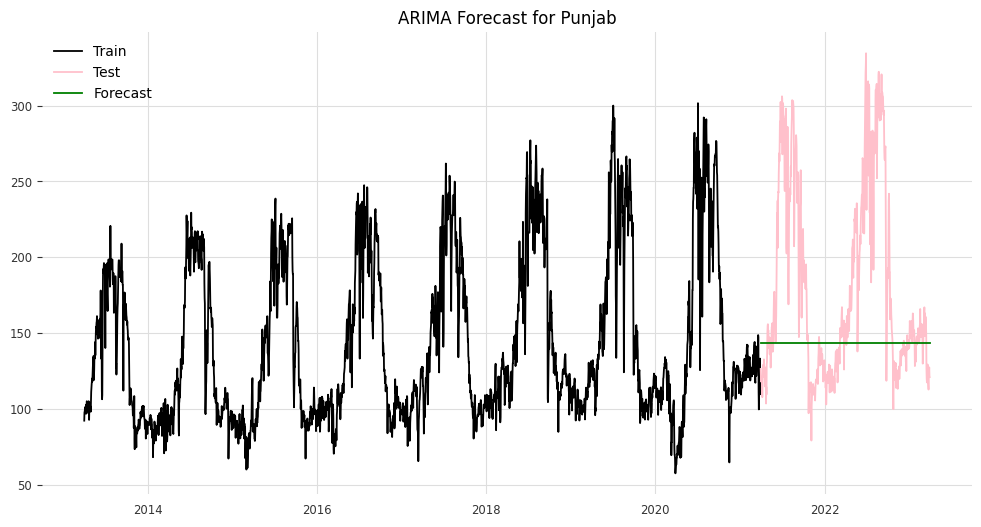

In [227]:
forecast = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12,6))
plt.plot(train.index, train["Energy Met (MU)"], label="Train")
plt.plot(test.index, test["Energy Met (MU)"], label="Test", color="pink")
plt.plot(test.index, forecast, label="Forecast", color="green")
plt.legend()
plt.title(f"ARIMA Forecast for {state}")
plt.show()


In [228]:
mae = mean_absolute_error(test["Energy Met (MU)"], forecast)
rmse = np.sqrt(mean_squared_error(test["Energy Met (MU)"], forecast))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 51.29, RMSE: 73.61


In [229]:
def evaluate_arima(train, test, order):
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps = len(test))
        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))
        return mae, rmse
    except Exception as e:
        return np.inf, np.inf

In [230]:
p_values = range(0,3)
d_values = range(0,2)
q_values = range(0,3)

best_score, best_config = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, q, d)
            mae, rmse = evaluate_arima(train["Energy Met (MU)"], test["Energy Met (MU)"], order)
            if rmse < best_score:
                best_score, best_config = rmse, order
            print(f"ARIMA{order} RMSE={rmse:.3f}")

print(f"\nBest ARIMA{best_config} RMSE={best_score:.3f}")

ARIMA(0, 0, 0) RMSE=73.612
ARIMA(0, 1, 0) RMSE=90.592
ARIMA(0, 2, 0) RMSE=2777.769


C:\Users\arman\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 1) RMSE=73.614
ARIMA(0, 1, 1) RMSE=90.073
ARIMA(0, 2, 1) RMSE=92.012
ARIMA(1, 0, 0) RMSE=74.034
ARIMA(1, 1, 0) RMSE=90.295
ARIMA(1, 2, 0) RMSE=783.023
ARIMA(1, 0, 1) RMSE=73.828
ARIMA(1, 1, 1) RMSE=89.589
ARIMA(1, 2, 1) RMSE=88.374
ARIMA(2, 0, 0) RMSE=73.869
ARIMA(2, 1, 0) RMSE=88.541
ARIMA(2, 2, 0) RMSE=1104.901


C:\Users\arman\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\arman\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 1) RMSE=73.866
ARIMA(2, 1, 1) RMSE=87.564
ARIMA(2, 2, 1) RMSE=86.387

Best ARIMA(0, 0, 0) RMSE=73.612


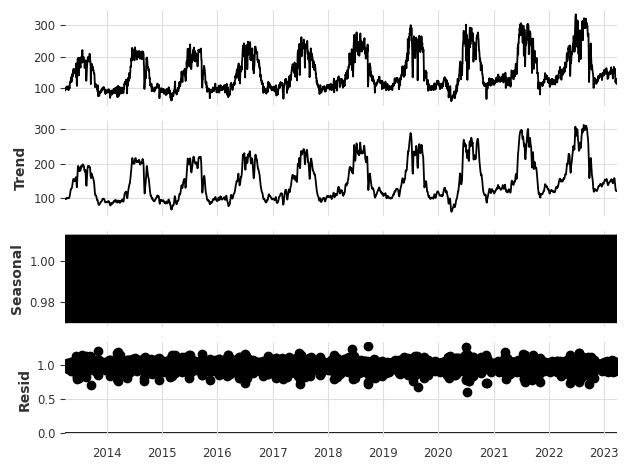

In [231]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(state_df, model='multiplicative')
result.plot()
plt.show()

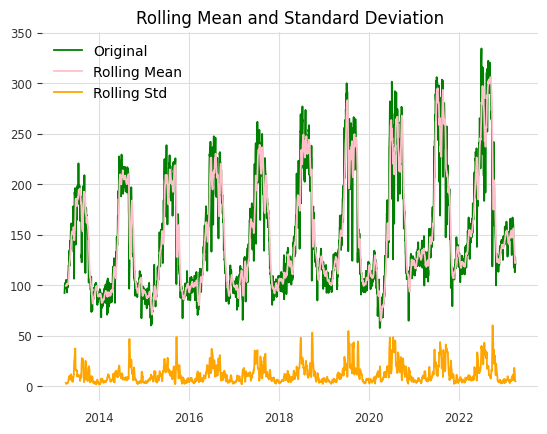

Results of the Dickey Fuller Test
Test Statistics                  -4.151415
p-value                           0.000795
No. of lags used                 27.000000
Number of observations used    3625.000000
critical value (1%)              -3.432155
critical value (5%)              -2.862338
critical value (10%)             -2.567195
dtype: float64


In [232]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color="green", label="Original")
    plt.plot(rolmean, color="pink", label="Rolling Mean")
    plt.plot(rolstd, color="orange", label="Rolling Std")
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of the Dickey Fuller Test")
    adft = adfuller(timeseries["Energy Met (MU)"], autolag='AIC')

    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(state_df)

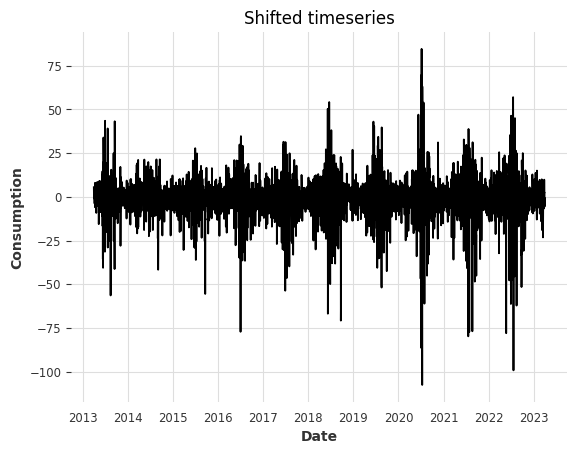

In [233]:
state_df_diff = state_df - state_df.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(state_df_diff)

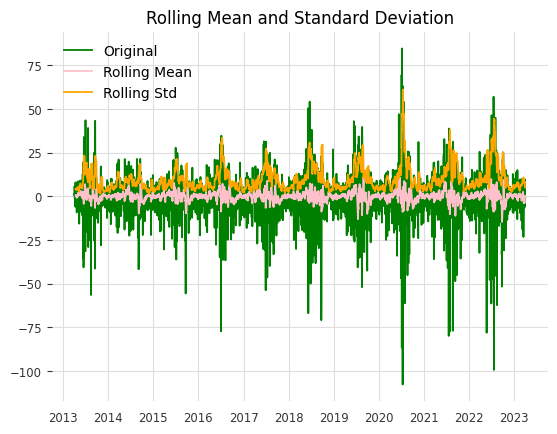

Results of the Dickey Fuller Test
Test Statistics               -1.269423e+01
p-value                        1.115074e-23
No. of lags used               2.600000e+01
Number of observations used    3.625000e+03
critical value (1%)           -3.432155e+00
critical value (5%)           -2.862338e+00
critical value (10%)          -2.567195e+00
dtype: float64


In [234]:
state_df_diff.dropna(inplace=True)
test_stationarity(state_df_diff)

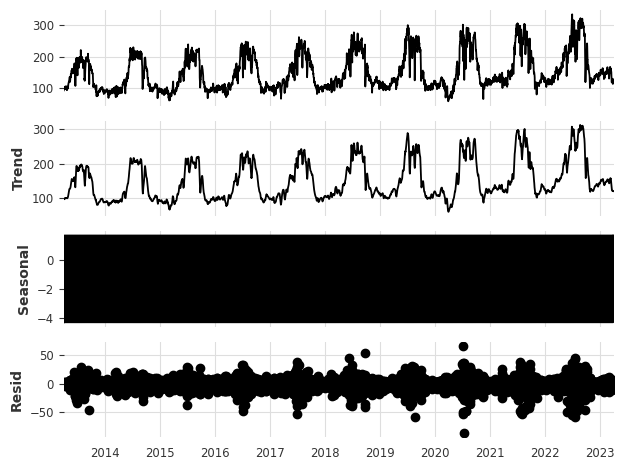

In [235]:
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(state_df, model='additive')
result.plot()
plt.show()

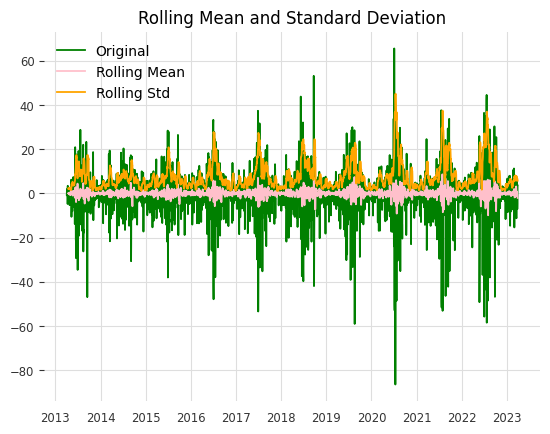

In [236]:
def test_stationarity_final(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='green',label='Original')
    plt.plot(rolmean, color='pink', label='Rolling Mean')
    plt.plot(rolstd, color='orange', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)



trend = result.trend
trend.dropna(inplace=True)
seasonality = result.seasonal
seasonality.dropna(inplace=True)
residual = result.resid
residual.dropna(inplace=True)
test_stationarity_final(residual)

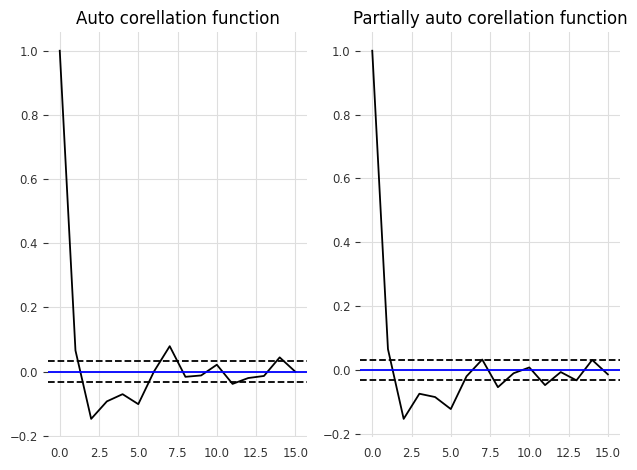

In [237]:
from statsmodels.tsa.stattools import acf, pacf

acf = acf(state_df_diff, nlags=15)
pacf = pacf(state_df_diff, nlags=15, method='ols')
plt.subplot(121)
plt.plot(acf)
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(state_df_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(state_df_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()

plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(state_df_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(state_df_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

In [238]:
train_size = int(len(state_df) * 0.97)

train, test = state_df.iloc[:train_size], state_df.iloc[train_size:]

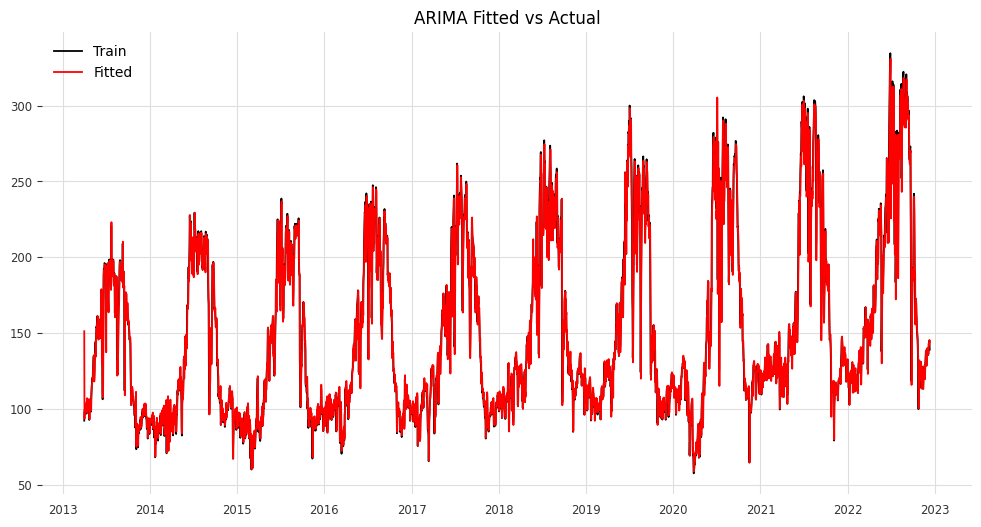

In [239]:
model = ARIMA(train["Energy Met (MU)"], order=(1,0,1))
result_AR = model.fit()

# Fitted values (in-sample)
fitted = result_AR.fittedvalues
plt.figure(figsize=(12,6))
plt.plot(train.index, train["Energy Met (MU)"], label="Train")
plt.plot(train.index, fitted, color='red', label="Fitted")
plt.title("ARIMA Fitted vs Actual")
plt.legend()
plt.show()

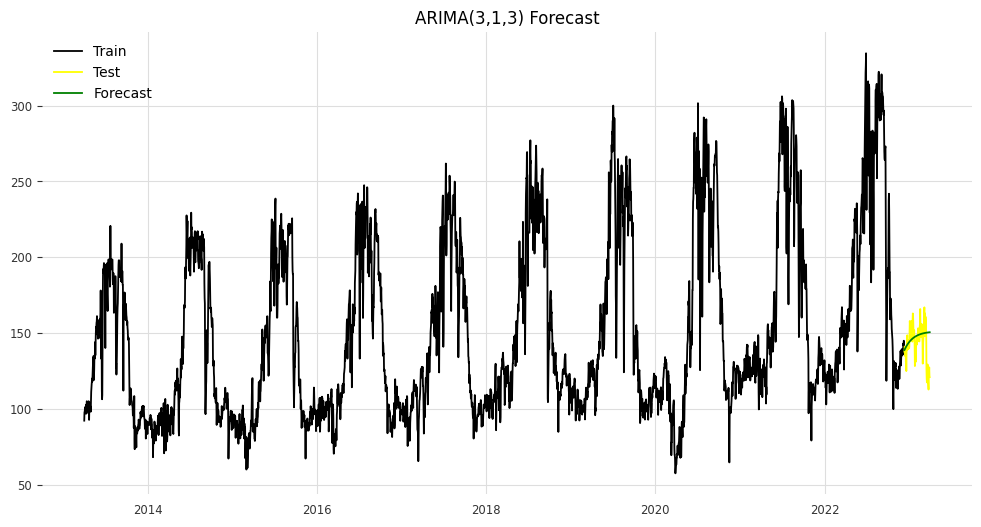

In [240]:
steps = len(test)
forecast = result_AR.forecast(steps=steps)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train["Energy Met (MU)"], label="Train")
plt.plot(test.index, test["Energy Met (MU)"], label="Test", color='yellow')
plt.plot(forecast.index, forecast, color='green', label="Forecast")
plt.title(f"ARIMA({3},{1},{3}) Forecast")
plt.legend()
plt.show()


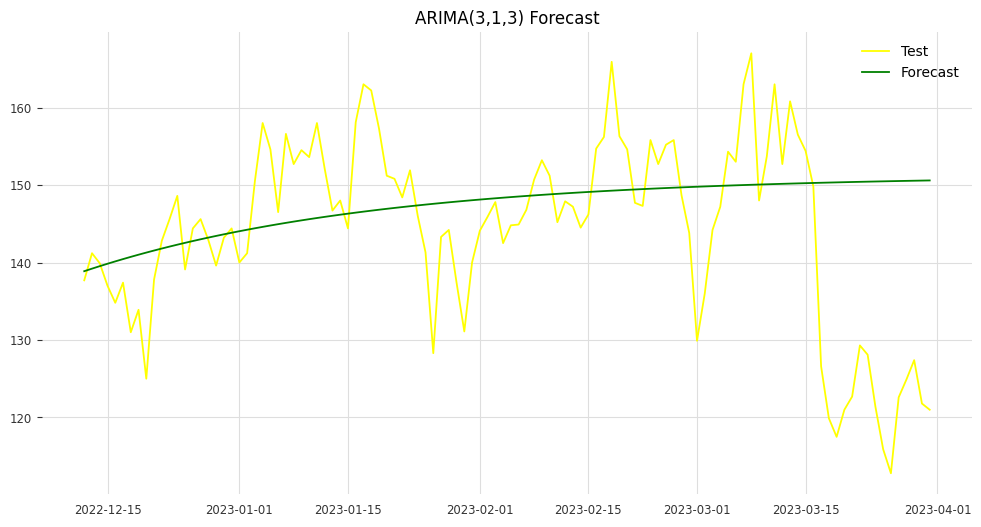

In [241]:
steps = len(test)
forecast = result_AR.forecast(steps=steps)

# Plot
plt.figure(figsize=(12,6))
plt.plot(test.index, test["Energy Met (MU)"], label="Test", color='yellow')
plt.plot(forecast.index, forecast, color='green', label="Forecast")
plt.title(f"ARIMA({3},{1},{3}) Forecast")
plt.legend()
plt.show()

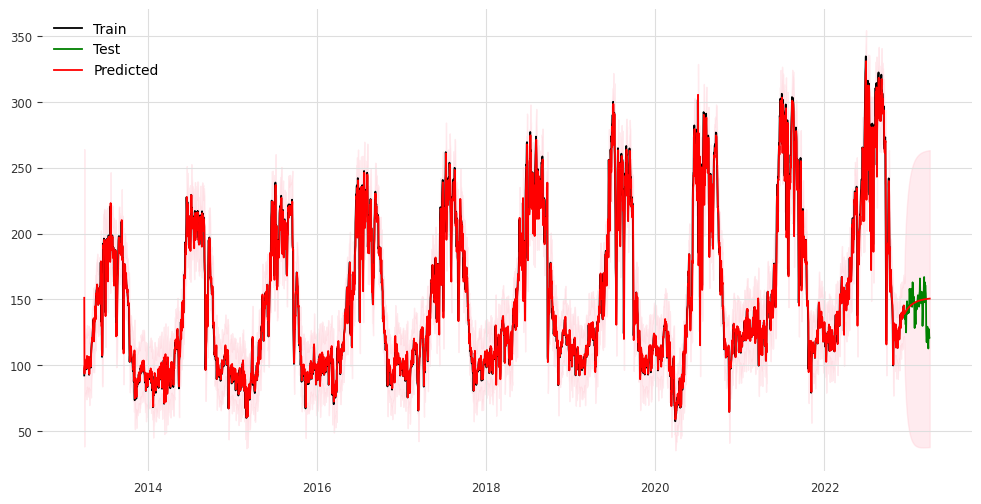

In [242]:
pred = result_AR.get_prediction(start=0, end=len(state_df))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

plt.figure(figsize=(12,6))
plt.plot(train.index, train["Energy Met (MU)"], label="Train")
plt.plot(test.index, test["Energy Met (MU)"], label="Test", color='green')
plt.plot(pred_mean.index, pred_mean, label="Predicted", color='red')
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.show()
